__Note__: to see the output of this notebook, see the [stochastic_large_ensemble.md file](../../results/examples/stochastic_large_ensemble/stochastic_large_ensemble.md).

# Overview: identifying a climate change "signal"

#### Motivation
The purpose of this tutorial is to demonstrate how models are used to assess climate change, or literally, a "change in climate". Why do we need models? One reason is that changes in climate, or the "background state" of the system, are often smaller than the internal variability of the system, meaning we need lots of samples – more than we have from observations – to estimate it accurately. 

As a concrete example, imagine the daily weather in Woods Hole is sampled from a probability distribution (e.g., 30% chance of rain, 70% chance of sun). Then the mean of this distribution (averaged over 30 years, for example) is the climate in Woods Hole, and the spread in this distribution (quantified by the standard deviation, for example) reflects natural variability. Climate *change*, in this example, corresponds to a shift in the mean of the probability distribution. Detecting a shift in the mean is harder if (i) the spread in the distribution is large compared to the shift or (ii) if we have a limited number of samples.  

Simulations from models increase the number of samples we can use to estimate the mean (and changes to the mean over time). Models also allow us to conduct "controlled" experiments, where, for example, we compare simulations with and without greenhouse gas emissions. In this context, the simulation without greenhouse gas emissions is the "control", which we're using as a baseline for comparison to the simulation *with* greenhouse gas emissions (the "experimental" simulation). One commonly used baseline is the "pre-industrial control", in which emission levels are fixed to pre-industrial levels and the model is run for a long time ($\sim1,000$ years).

#### Outline for this tutorial

To demonstrate these concepts, we'll look at a synthetic example, using a stochastic "climate model", where we know the "true" level of warming. We'll look at two ways of estimating climate and changes to it:
1. averaging over a large ensemble of "short" simulations
2. randomly sampling from a long pre-industrial control simulation

First, we'll simulate an artificial climate under two scenarios: a pre-industrial scenario and a warming scenario. For each scenario, we'll run lots of simulations, generating an ensemble. Averaging over the ensemble members at each time gives us an estimate of the mean state (the climate) and the natural variability in the system. Comparing the ensemble mean between the control and warming scenarios gives us an estimate of how much the climate has changed. 

Next, we'll estimate the control climate using a single (longer) pre-industrial control simulation. Because the climate in the control simulation is – by construction – not changing, we can estimate the climate by averaging over time, rather than over ensemble members. We'll show that the estimate for the pre-industrial climate using this approach is similar to that obtained from the ensemble approach.

[__Your task:__ assessing climate change using CMIP data.](#To-do:-assess-climate-change-using-CMIP-data) After going through this synthetic example, you'll assess climate change for your own climate index by comparing it between the "pre-industrial control" and "historical" scenarios of a chosen climate model.

## Imports

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cftime
import cartopy.crs as ccrs

## set plotting style
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## initialize random number generator
rng = np.random.default_rng()

## Stochastic climate model
Below is the implementation of the stochastic "climate model" (you shouldn't need to modify anything in this section to run the code below). For reference, we're numerically solving a version of Equation 3.6 from Frankignoul & Hasselmann (1977). We've decreased the damping rate compared to the paper for illustration purposes. In the paper, the authors are applying this equation to a different problem (the evolution of SST anomalies in the extratropics); here, we're repurposing it to describe climate variability on longer timescales.

Frankignoul, C. & Hasselmann, K. Stochastic climate models, Part II Application to sea-surface temperature anomalies and thermocline variability. Tellus 29, 289–305 (1977).

In [2]:
def get_T_bar(t, trend, trend_type="exp"):
    """Get 'background' temperature for stochastic climate model at times 't'.
    Args:
        - 't' is array of times (in units of years)
        - 'trend' is float representing linear trend in background temperature,
            computed based on initial and final background temperature (units of K/year)
        - 'trend_type' is one of {"exp","linear"}, indicating whether the shape
            of the background temperature curve should be exponential or linear
    """

    ## get final and initial times
    tf = t[-1]
    ti = t[0]

    ## get "background" temperature
    if trend_type == "exp":
        a = 3e-2
        b = trend * (tf - ti) * np.exp(-a * (tf - ti))
        T_bar = b * np.exp(a * (t - ti))

    elif trend_type == "linear":
        T_bar = (t - t[0]) * trend

    else:
        print("Not a valid trend type")
        T_bar = 0.0

    return T_bar


def markov_simulation(
    ti,
    tf,
    dt=1 / 365.25,
    g=-0.3,
    n=0.3,
    n_members=1,
    trend=0,
    trend_type="exp",
    nyears_spinup=10,
):
    """Minimal version of the 'stochastic climate model' studied
    by Hasselman et al (1976) and Frankignoul and Hasselmann (1977).
    (See Eqn 3.6 in Frankignoul and Hasselman, 1977). The damping rate
    used here is much lower than in the paper, for illustration purposes.
    Args:
        - ti: number representing initial time (units: years)
        - tf: number representing final time (units: years)
        - dt: timestep (units: years)
        - g: damping rate (equivalent to lambda in the paper; units: 1/year)
        - n: noise amplitude (units: K / year^{1/2})
        - n_members: number of ensemble members
        - trend: calculated increase in "background" T, with units of K/year
            (based on (T[tf]-T[ti]) / (tf-ti)
        - trend_type: one of "exp" (exponential) or "linear"
        - nyears_spinup: number of spinup years (discard these)
    """

    ## initialize RNG
    rng = np.random.default_rng()

    ## Get timesteps and dimensions for output
    t = np.arange(ti, tf, dt)
    nt = len(t)

    ## Create empty arrays arrays to hold simulation output
    T = np.zeros([n_members, nt])

    ## initialize with random value
    T[:, 0] = n * rng.normal(size=n_members)

    ## get "background" temperature
    T_bar = get_T_bar(t, trend, trend_type)[None, :]

    for i, t_ in enumerate(tqdm(t[:-1])):
        dW = np.sqrt(dt) * rng.normal(size=n_members)
        dT = g * (T[:, i] - T_bar[:, i]) * dt + n * dW
        T[:, i + 1] = T[:, i] + dT

    ##  put in xarray
    time_idx = xr.cftime_range(start=cftime.datetime(ti, 1, 1), periods=nt, freq="1D")
    e_member_idx = pd.Index(np.arange(1, n_members + 1), name="ensemble_member")

    T = xr.DataArray(
        T,
        dims=["ensemble_member", "time"],
        coords={"ensemble_member": e_member_idx, "time": time_idx},
    )

    ## resample to Annual
    T = T.resample({"time": "YS"}).mean()

    ## change time coordinate to year
    year = T.time.dt.year.values
    T = T.rename({"time": "year"})
    T["year"] = year

    ## discard model spinup
    T = T.isel(year=slice(nyears_spinup, None))

    return T

## Large ensemble approach

### Run stochastic climate model
First, we'll run the model under two scenarios: pre-industrial ("PI") control and warming. Below, specify the magnitude of the warming trend and the number of ensemble members for each scenario.

In [3]:
## specify number of ensemble members and end year for simulation
warming_trend = 0.002  # warming trend, in deg C / year
n_members = 5000  # number of ensemble members

## simulation pre-industrial and warming scenarios
T_PI = markov_simulation(
    ti=1850, tf=2006, n_members=n_members, trend=0, nyears_spinup=5
)
T_warming = markov_simulation(
    ti=1850, tf=2006, n_members=n_members, trend=warming_trend, nyears_spinup=5
)

## for convenience, get subset of pre-industrial control which overlaps with warming
T_PI_hist = T_PI.sel(year=T_warming.year)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56978/56978 [00:07<00:00, 7547.47it/s]


### Plot output from each scenario

#### Plot a few ensemble members

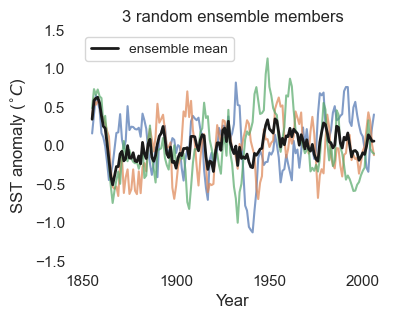

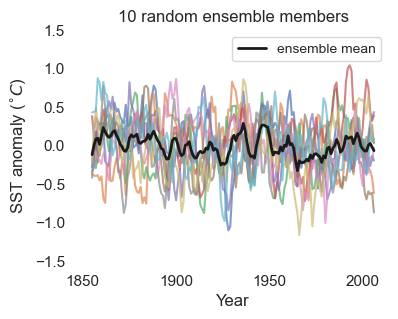

In [27]:
for ensemble_size in [3,10]:

    # choose random ensemble members
    idx = rng.choice(T_PI.ensemble_member, size=(ensemble_size))
    
    # make the plot
    fig, ax = plt.subplots(figsize=(4, 3))
    
    ## plot ensemble members
    for i in idx:
        
        ax.plot(
            T_PI_hist.year,
            T_PI_hist.sel(ensemble_member=i),
            alpha=0.7,
        )
    
    ## plot ensemble mean
    ax.plot(
        T_PI_hist.year,
        T_PI_hist.sel(ensemble_member=idx).mean("ensemble_member"),
        alpha=1,
        c="k",
        lw=2,
        label="ensemble mean",
    )
    
    
    ## label axes
    ax.set_xlabel("Year")
    ax.set_ylabel(r"SST anomaly ($^{\circ}C$)")
    ax.legend(prop={"size": 10})
    ax.set_title(f"{len(idx)} random ensemble members")
    ax.set_ylim([-1.5,1.5])
    # ax.set_
    
    plt.show()

First, look at a single ensemble member from each scenario.

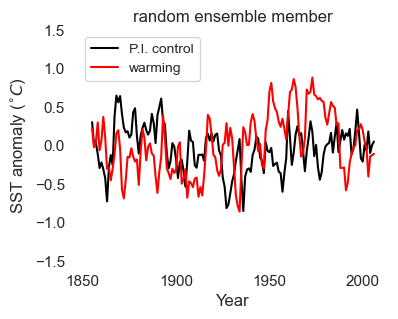

In [18]:
# choose a random sample
idx = rng.choice(T_PI.ensemble_member)

# make the plot
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(
    T_PI_hist.year,
    T_PI_hist.sel(ensemble_member=idx),
    color="black",
    label="P.I. control",
)
ax.plot(
    T_warming.year, T_warming.sel(ensemble_member=idx), color="red", label="warming"
)

## label axes
ax.set_xlabel("Year")
ax.set_ylabel(r"SST anomaly ($^{\circ}C$)")
ax.legend(prop={"size": 10})
ax.set_title("random ensemble member")
ax.set_ylim([-1.5,1.5])

plt.show()

Next, let's look at the ensemble mean and spread. To quantify the spread, we'll compute the standard deviation.

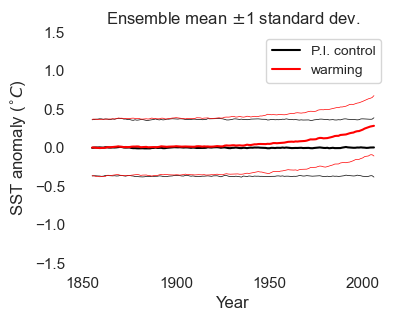

In [17]:
def plot_ensemble_spread(ax, T, color, label=None):
    """plot mean and +/- 1 standard dev. of ensemble on
    given ax object."""

    ## compute stats
    mean = T.mean("ensemble_member")
    std = T.std("ensemble_member")

    ## plot mean
    mean_plot = ax.plot(mean.year, mean, label=label, color=color)

    ## plot spread
    ax.plot(mean.year, mean + std, lw=0.5, c=mean_plot[0].get_color())
    ax.plot(mean.year, mean - std, lw=0.5, c=mean_plot[0].get_color())

    return


## Plot ensemble stats
fig, ax = plt.subplots(figsize=(4, 3))

## plot data
plot_ensemble_spread(ax, T_PI_hist, color="black", label="P.I. control")
plot_ensemble_spread(ax, T_warming, color="red", label="warming")

## label axes
ax.set_xlabel("Year")
ax.set_ylabel(r"SST anomaly ($^{\circ}C$)")
ax.legend(prop={"size": 10})
ax.set_title(r"Ensemble mean $\pm$1 standard dev.")
ax.set_ylim([-1.5,1.5])

plt.show()

### Assessing climate change

Next, we'll return to the probabilistic view of climate and weather. One straightforward approach would be to compute SST histograms for each scenario at the end of the simulation, and compare them (one could ask "are the means of these distributions significantly different?"). We'll ask a slightly more involved question: is the linear trend in SST over the last 40 years statistically significant?

To do this, we'll compute the linear trend in each ensemble member, then create a histogram of trends for each scenario. Finally, we'll compare the histograms for PI control and warming scenarios.

Below, we write functions to compute the linear trend (```get_slope```), to estimate the probability distribution function (```get_pdf```), and to plot the results.

In [27]:
def get_slope(data, dim="year"):
    """Function to compute linear trend of SST,
    in deg/century."""

    ## fit linear trend to data
    coefs = data.polyfit(dim=dim, deg=1)["polyfit_coefficients"]

    ## Get slope (degree=1; intercept is given by degree=0).
    ## Note: units are in deg/year
    slope = coefs.sel(degree=1)

    ## convert units to deg/century
    slope *= 100

    return slope


def get_pdf(samples):
    """function to get probability distribution function from samples"""

    ## First, make a histogram.

    # specify bin edges for histogram
    bin_width = 0.5
    bin_edges = np.arange(-4.75, 4.75 + bin_width, bin_width)

    # compute histogram
    hist, _ = np.histogram(samples, bins=bin_edges)

    ## normalize, to form PDF
    norm_factor = (bin_width * hist).sum()
    pdf = hist / norm_factor

    return pdf, bin_edges


def plot_pdf_comparison(ax, samples0, samples1, label0=None, label1=None, color1="r"):
    """
    Plot comparison of 2 PDFs on the specified ax object, and label them
    'label0' and 'label1', respectively. 'color1' is the color for PDF calculated
    from 'samples1' (only the outline of pdf for 'samples1' is plotted).
    """

    ## calculate PDFs
    pdf0, bin_edges = get_pdf(samples0)
    pdf1, _ = get_pdf(samples1)

    ## plot histograms
    ax.stairs(values=pdf0, edges=bin_edges, color="k", label=label0)
    ax.stairs(
        values=pdf1,
        edges=bin_edges,
        color=color1,
        label=label1,
        fill=True,
        alpha=0.3,
    )

    ## label plot
    ax.set_ylabel("Prob.")
    ax.set_xlabel(r"Warming trend ($^{\circ}C~/~$century)")

    return ax


def plot_pdf_comparison_wrapper0(ax, years):
    """wrapper function to plot histogram comparison for given subset of years"""

    ## Get trends for each ensemble member
    trends_PI = get_slope(T_PI.sel(year=years))
    trends_warming = get_slope(T_warming.sel(year=years))

    ## make the plot
    ax = plot_pdf_comparison(
        ax,
        samples0=trends_PI,
        samples1=trends_warming,
        label0="PI control",
        label1="warming",
    )

    ## plot ensemble means
    ax.axvline(trends_PI.mean(), ls="--", c="k", lw=1)
    ax.axvline(trends_warming.mean(), ls="--", c="r", lw=1)

    return ax

Next, we apply these functions

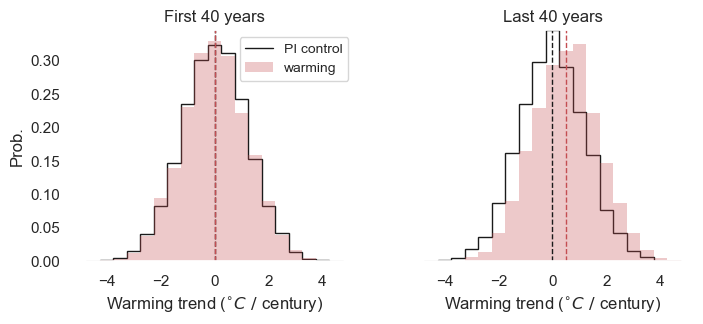

In [28]:
## Get years to compare
nyears = 40
early_years = T_warming.year.values[:nyears]
late_years = T_warming.year.values[-nyears:]

## Make plot
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

## Plot data for each subset of years
axs[0] = plot_pdf_comparison_wrapper0(axs[0], years=early_years)
axs[1] = plot_pdf_comparison_wrapper0(axs[1], years=late_years)

## label plot
axs[0].set_title(f"First {nyears} years")
axs[1].set_title(f"Last {nyears} years")
axs[0].legend(prop={"size": 10})
axs[1].set_yticks([])
axs[1].set_ylabel(None)
axs[1].set_ylim(axs[0].get_ylim())

plt.show()

## Random sampling approach

Next, we'll do the same exercise but will estimate the PDF/histogram for the pre-industrial control in a different way: using a single, long simulation. Whereas before we used a large ensemble of pre-industrial simulations (each spanning the period 1850-2006), here we'll use a single, 1,000-year long simulation. To compute the histogram, we'll select random (overlapping) 40-year samples from the simulation, rather than averaging over ensemble members. 

First, run the long simulation:

In [29]:
## 1,000 year simulation
T_PI_long = markov_simulation(ti=1000, tf=2000, n_members=1, trend=0, nyears_spinup=5)

## get rid of ensemble dimension
T_PI_long = T_PI_long.isel(ensemble_member=0, drop=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 365249/365249 [00:02<00:00, 133072.98it/s]


Next, some functions to select random samples from the simulation.

In [30]:
def get_random_sample(nyears):
    """function draws a random sample from T_PI_long,
    and computes trend. 'nyears' is length of sample"""

    ## get start year for trend
    max_idx = len(T_PI_long.year) - nyears
    idx_start = rng.choice(np.arange(0, max_idx))

    ## get data subset
    T_PI_sample = T_PI_long.isel(year=slice(idx_start, idx_start + nyears))

    ## compute trend for sample
    return get_slope(T_PI_sample)


def get_random_samples(nsamples, nyears):
    """get multiple random samples"""

    ## get random samples
    samples = [get_random_sample(nyears) for _ in tqdm(np.arange(nsamples))]

    ## Put in xr.DataArray.
    sample_dim = pd.Index(np.arange(nsamples), name="sample")
    samples = xr.concat(samples, dim=sample_dim)
    return samples


## get random samples
samples = get_random_samples(nsamples=len(T_PI.ensemble_member), nyears=40)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1463.93it/s]


Finally, compare the histogram estimated using the ensemble mean approach to the histogram estimated using the random sampling (or "Monte-Carlo") approach.

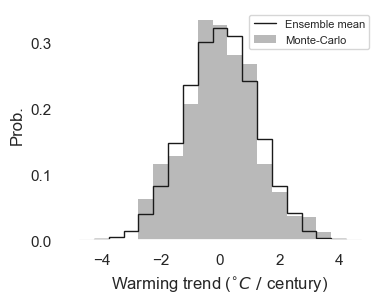

In [31]:
fig = plt.figure(figsize=(4, 3))
ax = fig.add_subplot()

ax = plot_pdf_comparison(
    ax,
    samples0=get_slope(T_PI.sel(year=early_years)),
    samples1=samples,
    label0="Ensemble mean",
    label1="Monte-Carlo",
    color1="k",
)

ax.legend(prop={"size": 8})

plt.show()

# To-do: assess climate change using CMIP data
Your task is to determine whether there is a long-term change in your climate index. To do this, you'll compare the index between a pre-industrial control simulation and historical simulation, both from the CMIP model you validated in the last step of the tutorial. In more detail, one possible approach is:

1. Compute the index in the model's pre-industrial control simulation and in the historical simulation.
2. Choose a "climate timescale" of $n$ years to evaluate your index's long-term mean (e.g., in the example above, we used $n=40$ years). Then create a "baseline" histogram for your index by randomly sampling $n$-year segments from the PI control simulation and computing the mean over each sample.
3. Evaluate the mean of the first-$n$ years and the last-$n$ years in the *historical* simulation.
4. Where do the values estimated from the historical simulation fall on the histogram created from the PI-control simulation? Are they significantly different from the mean of the histogram?

__Bonus:__ repeat steps (3) and (4), but for a future warming scenario instead of the historical scenario. The future warming scenarios are denoted by "RCP" in CMIP5 and "SSP" in CMIP6.